In [124]:
import os
import random
import re

import matplotlib.patches as mpathes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import ticker
from numba import jit
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
from PqiDataSdk import PqiDataSdk

ds = PqiDataSdk(user="zyding", size=128, pool_type="mt")

In [3]:
with open('/home/zyding/xtech/XTECH_factor_name.txt') as f:
    lst_xtech_factor_name = eval(f.read())

In [4]:
lst_xtech_factor_name = [name+'.csv' for name in lst_xtech_factor_name]

In [5]:
tickers = ds.get_ticker_list(date='all')
start_date = '20170101'
end_date = '20201231'
lst_trade_date = ds.get_trade_dates(start_date=start_date, end_date=end_date)


path_xtech = '/home/zyding/xtech/'

In [6]:
# 将原始csv转换为树状结构的二维表
def get_stacked_factor(path, name):
    df = pd.read_csv(path + name, dtype={0: str})
    df.set_index(df.iloc[:, 0], inplace=True)
    df.index.name = None
    df = pd.DataFrame(index=tickers, columns=lst_trade_date, data=df)
    return df.stack(dropna=False)

In [7]:
idx = get_stacked_factor(path_xtech, lst_xtech_factor_name[0]).index

In [28]:
df_factor_all = pd.DataFrame(index=idx)

In [29]:
# 构建因子总表，为二级index（ticker，日期），一级column（因子）
for name in tqdm(lst_xtech_factor_name):
    df_factor_all[name[:-4]] = get_stacked_factor(path_xtech, name)

100%|██████████| 97/97 [01:27<00:00,  1.11it/s]


In [10]:
df_factor_all.dropna(how='all', inplace=True)

<AxesSubplot:ylabel='Frequency'>

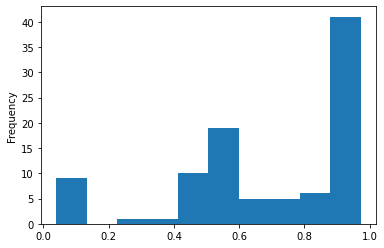

In [11]:
(df_factor_all.count()/len(df_factor_all)).plot(kind='hist')  # 各因子非空值占比可视化

In [12]:
(df_factor_all.count()/len(df_factor_all)).describe()  # 因子非空值占比描述性统计

count   97.000
mean     0.685
std      0.279
min      0.039
25%      0.572
50%      0.781
75%      0.923
max      0.972
dtype: float64

In [18]:
df_factor_all = df_factor_all.loc[:,
                                  df_factor_all.count()/len(df_factor_all) > 0.4]

In [19]:
df_factor_all

quant_18  quant_32  quant_4  any_cor_FACTORS_mom_cl  \
000001 20170103       nan       nan      nan                     nan   
       20170104       nan       nan      nan                     nan   
       20170105       nan       nan      nan                     nan   
       20170106       nan       nan      nan                     nan   
       20170109       nan       nan      nan                     nan   
...                   ...       ...      ...                     ...   
689009 20201225     0.231     0.041    0.003                     nan   
       20201228     0.321     0.032    0.004                     nan   
       20201229     0.032     0.003    0.004                     nan   
       20201230     0.065    -0.003    0.004                     nan   
       20201231    -0.191    -0.020    0.003                     nan   

                 flow_FACTORS_main  flow_FACTORS_small  fund_FACTORS_TVSTD6  \
000001 20170103                nan                 nan               61.420   
       20170104                nan                 nan               72.466   
       20170105                nan                 nan               61.221   
       20170106                nan                 nan               59.377   
       20170109                nan                 nan               57.332   
...                            ...                 ...                  ...   
689009 20201225             -0.077              -0.094               87.706   
       20201228             -0.084              -0.102               89.981   
       20201229                nan                 nan               78.991   
       20201230             -0.096              -0.102               53.235   
       20201231             -0.094              -0.095               50.429   

                 fund_FACTORS_num  fund_FACTORS_pct  guba_FACTORS_post  ...  \
000001 20170103               nan               nan             37.000  ...   
       20170104               nan               nan             44.000  ...   
       20170105               nan               nan             31.000  ...   
       20170106               nan               nan             49.000  ...   
       20170109               nan               nan             35.000  ...   
...                           ...               ...                ...  ...   
689009 20201225               nan               nan             77.000  ...   
       20201228               nan               nan             58.000  ...   
       20201229               nan               nan                nan  ...   
       20201230               nan               nan             51.000  ...   
       20201231               nan               nan             51.000  ...   

                 minute_FACTORS_kurtosis  minute_FACTORS_skewness  \
000001 20170103                   14.734                    3.457   
       20170104                   12.954                    3.039   
       20170105                   16.661                    3.458   
       20170106                   17.534                    3.709   
       20170109                   11.708                    3.030   
...                                  ...                      ...   
689009 20201225                    4.403                    0.613   
       20201228                    4.429                    0.620   
       20201229                    4.459                    0.623   
       20201230                    4.382                    0.615   
       20201231                    4.267                    0.599   

                 minute_FACTORS_weipan  py_cov_FACTORS_PV_Corr  \
000001 20170103                  0.091                     nan   
       20170104                  0.042                     nan   
       20170105                  0.038                     nan   
       20170106                  0.044                     nan   
       20170109                  0.039                     nan   
...                          

In [20]:
# 因子值变换为每日全股票池排序值（百分比）
def transform_rank_percent(df):
    temp = df.reset_index()
    temp = temp.groupby(temp['level_1']).rank(pct=True)
    return pd.DataFrame(index=df.index, columns=df.columns, data=temp.values)

In [21]:
%time df_factor_rank_percent = transform_rank_percent(df_factor_all)

CPU times: user 52.1 s, sys: 1.28 s, total: 53.4 s
Wall time: 53.5 s


In [179]:
df_combo_equal = df_factor_rank_percent.mean(axis=1).unstack()  # 等权合成

In [180]:
df_combo_equal

,20170103,20170104,20170105,20170106,20170109,20170110,20170111,20170112,20170113,20170116,...,20201218,20201221,20201222,20201223,20201224,20201225,20201228,20201229,20201230,20201231
000001,0.568,0.552,0.551,0.550,0.519,0.522,0.529,0.534,0.539,0.546,...,0.542,0.556,0.556,0.551,0.563,0.530,0.547,0.542,0.577,0.608
000002,0.628,0.626,0.638,0.584,0.576,0.555,0.569,0.500,0.601,0.606,...,0.537,0.532,0.546,0.541,0.543,0.541,0.526,0.515,0.526,0.554
000003,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0.094,0.092,0.095,0.095,0.094,0.094,0.092,0.095,0.095,0.093
000004,0.498,0.505,0.475,0.494,0.521,0.554,0.534,0.504,0.511,0.459,...,0.507,0.471,0.483,0.468,0.514,0.518,0.460,0.475,0.451,0.445
000005,0.495,0.550,0.526,0.544,0.509,0.486,0.490,0.500,0.502,0.485,...,0.414,0.422,0.405,0.415,0.393,0.397,0.420,0.413,0.395,0.399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688699,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0.802,0.813,0.783,0.721,0.704,0.674,0.687,0.798,0.638,0.583
688777,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0.687,0.679,0.646,0.599,0.623,0.615,0.595,0.629,0.599,0.565
688788,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0.459,0.457,0.485,0.466,0.476,0.475,0.474,0.532,0.476,0.443
688981,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0.622,0.628,0.633,0.628,0.634,0.637,0.635,0.625,0.676,0.689


In [177]:
def save_factor(name,
                df_factor,
                path='/home/zyding/factor_zyding/eod_xtech',
                feature_type='eod'):
    ds.save_eod_feature(data={name: df_factor},
                        where=path,
                        feature_type=feature_type,
                        encrypt=False)

In [181]:
save_factor('eod_combo_xtech_equal', df_combo_equal)

**考虑因子方向（正/负）**

In [28]:
df_factor_all = pd.DataFrame(index=idx)

In [29]:
# 构建因子总表，为二级index（ticker，日期），一级column（因子）
for name in tqdm(lst_xtech_factor_name):
    df_factor_all[name[:-4]] = get_stacked_factor(path_xtech, name)

100%|██████████| 97/97 [01:27<00:00,  1.11it/s]


In [45]:
eod_data = ds.get_eod_history(fields=['OpenPrice', 'ClosePrice'],
                              tickers=tickers,
                              start_date='20170101',
                              end_date='20201231',
                              day_type='trade',
                              price_mode='former')

In [54]:
df_ret_eod = eod_data['ClosePrice'].apply(lambda x: x/x.shift()-1, axis=1)
df_ret_eod = df_ret_eod.shift(-1, axis=1).stack(dropna=False)

In [62]:
df_factor_all['ret'] = df_ret_eod

In [69]:
df_factor_all_reset = df_factor_all.reset_index()

In [81]:
grouped_factor_all = df_factor_all.reset_index().groupby('level_1')

In [110]:
def calc_ic(df, method):
    return df.apply(lambda x: x.corr(df.iloc[:, -1], method))

In [136]:
tqdm.pandas()
df_factor_ic = df_factor_all_reset.iloc[:, 1:].groupby(
    'level_1').progress_apply(calc_ic, method='pearson')
df_factor_rankic = df_factor_all_reset.iloc[:, 1:].groupby(
    'level_1').progress_apply(calc_ic, method='spearman')

  1%|          | 8/974 [00:05<21:26,  1.33s/it]/shared/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
  0%|          | 1/974 [00:01<31:52,  1.97s/it]/shared/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
100%|██████████| 974/974 [01:36<00:00, 10.13it/s]


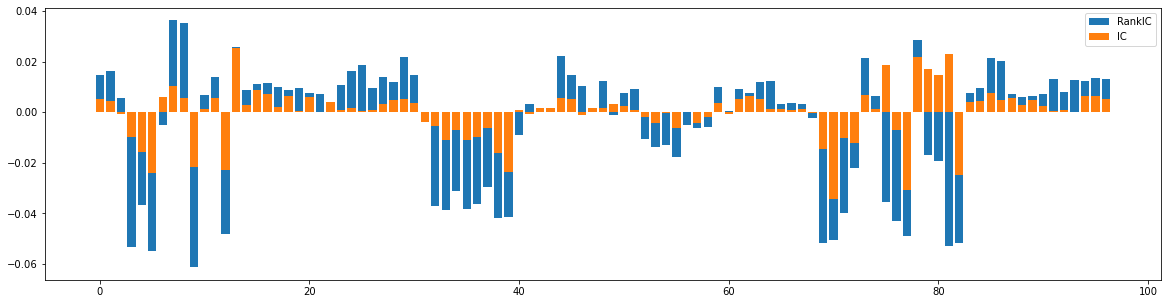

In [172]:
plt.figure(figsize=(20, 5))
plt.bar(np.arange(97), df_factor_rankic.iloc[:, 1:-1].mean(), label='RankIC')
plt.bar(np.arange(97), df_factor_ic.iloc[:, :-1].mean(), label='IC')
plt.legend()

In [206]:
df_factor_ic_mean = df_factor_ic.mean()[:-1]
df_factor_rankic_mean = df_factor_rankic.mean()[1:-1]

In [210]:
df_factor_all = df_factor_all.iloc[:, :-1]

**IC等权（排序前）**

In [211]:
%%time
df_factor_ic_equal_rank_percent = transform_rank_percent(
    df_factor_all*np.where(df_factor_ic_mean >= 0, 1, -1))

df_combo_ic_equal_before = df_factor_ic_equal_rank_percent.mean(
    axis=1).unstack()

save_factor('eod_combo_xtech_ic_equal_before', df_combo_ic_equal_before)

CPU times: user 1min 2s, sys: 2.83 s, total: 1min 5s
Wall time: 1min 6s


**IC等权（排序后）**

In [212]:
df_factor_rank_pct = transform_rank_percent(df_factor_all)

df_combo_ic_equal_after = (
    df_factor_rank_pct * np.where(df_factor_ic_mean >= 0, 1, -1)).mean(axis=1).unstack()

save_factor('eod_combo_xtech_ic_equal_after', df_combo_ic_equal_after)

**IC加权（排序前）**

In [213]:
df_factor_ic_weighted_rank_percent = transform_rank_percent(df_factor_all *
                                                            df_factor_ic_mean)
df_combo_ic_weighted_before = df_factor_ic_weighted_rank_percent.mean(
    axis=1).unstack()
save_factor('eod_combo_xtech_ic_weighted_before', df_combo_ic_weighted_before)

**IC加权（排序后）**

In [214]:
df_combo_ic_weighted_after = (
    df_factor_rank_pct * df_factor_ic_mean).mean(axis=1).unstack()
save_factor('eod_combo_xtech_ic_weighted_after', df_combo_ic_weighted_after)

**RankIC等权（排序前）**

In [215]:
%time df_factor_rankic_equal_rank_percent = transform_rank_percent(df_factor_all*np.where(df_factor_rankic_mean>=0,1,-1))
df_combo_rankic_equal_before = df_factor_rankic_equal_rank_percent.mean(
    axis=1).unstack()
save_factor('eod_combo_xtech_rankic_equal_before',
            df_combo_rankic_equal_before)

CPU times: user 59.9 s, sys: 2.59 s, total: 1min 2s
Wall time: 1min


**RankIC等权（排序后）**

In [216]:
df_combo_rankic_equal_after = (
    df_factor_rank_pct * np.where(df_factor_rankic_mean >= 0, 1, -1)).mean(axis=1).unstack()

save_factor('eod_combo_xtech_rankic_equal_after', df_combo_rankic_equal_after)

**RankIC加权（排序前）**

In [217]:
df_factor_rankic_weighted_rank_percent = transform_rank_percent(
    df_factor_all * df_factor_rankic_mean)
df_combo_rankic_weighted_before = df_factor_rankic_weighted_rank_percent.mean(
    axis=1).unstack()
save_factor('eod_combo_xtech_rankic_weighted_before',
            df_combo_rankic_weighted_before)

**RankIC加权（排序后）**

In [218]:
df_combo_rankic_weighted_after = (
    df_factor_rank_pct * df_factor_rankic_mean).mean(axis=1).unstack()
save_factor('eod_combo_xtech_rankic_weighted_after',
            df_combo_rankic_weighted_after)

**大类因子归并**

In [252]:
idx_factor_pfx = df_factor_all.columns.str.split(
    '_').map(lambda x: x[0]).unique()  # 前缀
idx_factor_pfx = idx_factor_pfx.drop(['any', 'hkholders', 'HK'])

In [256]:
dict_factor_category = {
    x: df_factor_rankic_equal_rank_percent.
    loc[:, df_factor_rankic_equal_rank_percent.columns.str.contains(x)].mean(
        axis=1).unstack() for x in idx_factor_pfx
}

In [264]:
for name in dict_factor_category.keys():
    save_factor(f'eod_combo_xtech_cat_{name}', dict_factor_category[name])

In [285]:
os.chdir('/home/zyding/low_fre_backtest_plot/')

In [286]:
def runBacktest(path_config, name):
    with open(path_config, 'r+') as f:
        content = f.readlines()
        content[0] = f"combo_name = 'eod_combo_xtech_cat_{name}'\n"
    with open(path_config, 'w+') as f:
        f.writelines(content)
    os.system('python main.py')

In [287]:
for name in tqdm(dict_factor_category.keys()):
    runBacktest('/home/zyding/low_fre_backtest_plot/configuration.py', name)

100%|██████████| 18/18 [57:30<00:00, 191.71s/it]


In [289]:
df_factor_rankic_equal_rank_percent.loc[:,
                                        df_factor_rankic_equal_rank_percent.columns.str.contains('winrate')]

winrate_FACTORS_prob
000001 20170103                 0.929
       20170104                 0.929
       20170105                 0.929
       20170106                 0.929
       20170109                 0.929
...                               ...
689009 20201225                   nan
       20201228                   nan
       20201229                   nan
       20201230                   nan
       20201231                   nan

[4738510 rows x 1 columns]

<AxesSubplot:xlabel='level_1'>

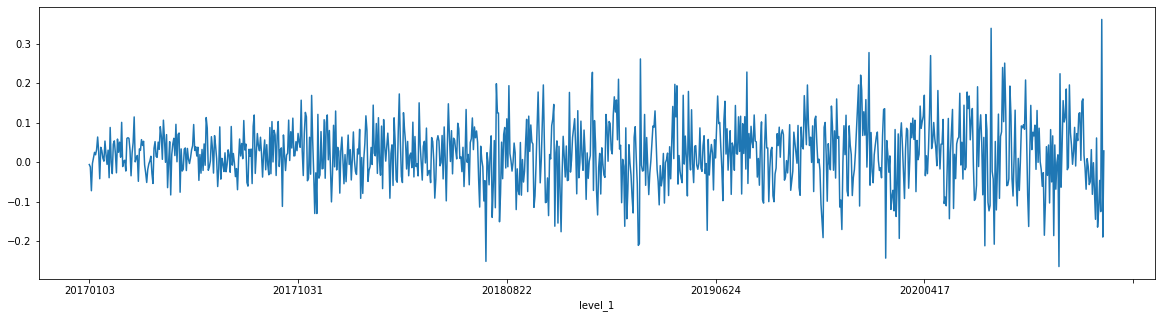

In [311]:
df_factor_rankic['winrate_FACTORS_prob'].plot(figsize=(20, 5))

In [329]:
dict_factor_select60pct = {
    x: dict_factor_category[x].stack(dropna=False) for x in [
        'winrate', 'jq', 'hk', 'suntime', 'income', 'quant', 'zhaopin', 'py',
        'liangjia', 'ecom', 'emall'
    ]
}

In [330]:
df_combo_cat_select60pct = pd.concat(
    dict_factor_select60pct.values(), axis=1).mean(axis=1).unstack()

In [331]:
save_factor('eod_combo_xtech_cat_select60pct', df_combo_cat_select60pct)

In [332]:
dict_factor_select50pct = {
    x: dict_factor_category[x].stack(dropna=False) for x in [
        'winrate', 'jq', 'hk', 'suntime', 'income', 'quant', 'zhaopin', 'py'
    ]
}
df_combo_cat_select50pct = pd.concat(
    dict_factor_select50pct.values(), axis=1).mean(axis=1).unstack()
save_factor('eod_combo_xtech_cat_select50pct', df_combo_cat_select50pct)